In [1]:
import flopy; import sys; import pathlib; import os; import time; import numpy as np; import matplotlib.pyplot as plt
import pandas as pd
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\01_MT3D_Wisconsin-Madison\08


In [2]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\01_MT3D_Wisconsin-Madison\\08')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'macrodispersion_illustration'           ; workdir = os.path.join('.', directory_name)
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
folder_w_datafile = ('E:\\15_REPOS\\00_BETAMI\\98_Plus\\01_MT3D_Wisconsin-Madison\\data_for_models')
datafile_name1 = 'anisotropic_perm_field_sig100.csv'       ; data_file_with_path1 = os.path.join(folder_w_datafile, datafile_name1)             
datafile_name2 = 'anisotropic_perm_field_sig100000.csv'    ; data_file_with_path2 = os.path.join(folder_w_datafile, datafile_name2) 

In [3]:
kdata_m2   = np.loadtxt(data_file_with_path1, delimiter=',')                        # anisotropic_perm_field_sig100.csv
nrow       = int(kdata_m2[-2])       ; ncol = int(kdata_m2[-1])                   ; print('Nrows = ' + str(nrow), 'Ncolumns = ' + str(ncol))
kdata_m2   = kdata_m2[0:-2]          ; rawk_m2 = kdata_m2.reshape(1, nrow, ncol)  ; # print('Vector = ', kdata_m2.shape)   
hk_weak    = rawk_m2*(1000*9.81*100/8.9E-4)                                         # Permeabiltiy (in m^2) to K (cm/sec)

kdata_m2   = np.loadtxt(data_file_with_path2, delimiter=',')                      ; print('kdata_m2.shape', kdata_m2.shape)
nrow       = int(kdata_m2[-2])       ; ncol = int(kdata_m2[-1])                   ; # print('Nrows = ' + str(nrow), 'Ncolumns = ' + str(ncol))
kdata_m2   = kdata_m2[0:-2]          ; rawk_m2 = kdata_m2.reshape(1, nrow, ncol)  ; # print('Vector = ', kdata_m2.shape)   
hk_strong  = rawk_m2*(1000*9.81*100/8.9E-4)                                         # ________________________________________ sa = rawk_m2[0,:,:]

geo_mean_weak   = np.exp(np.sum(np.log(hk_weak))   / hk_weak.size)                ; print('K      =', geo_mean_weak,   'cm/sec')
geo_mean_strong = np.exp(np.sum(np.log(hk_strong)) / hk_strong.size)              ; print('Kstrong=', geo_mean_strong, 'cm/sec')
hk_hom          = geo_mean_weak*np.ones([1, 20, 40]) ; perlen_mt = [60*3,60*58]   ; v = 0.01 ; al = 0.2 ; trpt = 0.1 ; itype= -1

Nrows = 20 Ncolumns = 40
kdata_m2.shape (802,)
K      = 0.0005412218263527298 cm/sec
Kstrong= 0.0007188879381530694 cm/sec


In [4]:
sa = kdata_m2.reshape(nrow, ncol) ; save = pd.DataFrame(sa) ; save.to_csv ("01_anis_perm_field_.csv"); # print('bdata_m2.shape',bawk_m2.shape)

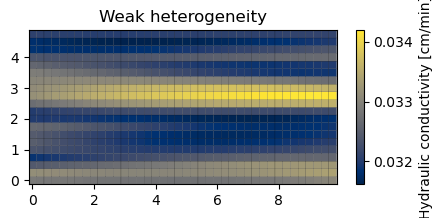

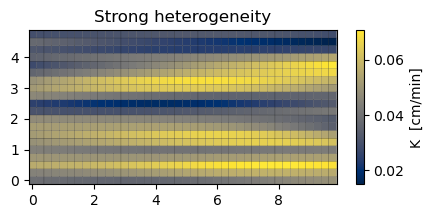

In [19]:
grid_size = [0.25, 0.25] ;         Lx = (ncol - 1) * grid_size[1]   ; Ly = (nrow - 1) * grid_size[0]   
y, x = np.mgrid[slice(0, Ly + grid_size[0], grid_size[0]),  slice(0, Lx + grid_size[1], grid_size[1])]

def plot_2d(map_data, X, Y, cmap, colorbar_label, title_text):
    plt.figure(figsize=(5, 2), dpi=100)                        ; plt.pcolor(X,Y,map_data,cmap=cmap,shading='auto',edgecolor='k',linewidth=0.1)
    plt.gca().set_aspect('equal') ; cbar = plt.colorbar()      ; cbar.set_label(colorbar_label);  plt.title(title_text)
plot_2d(hk_weak[0,:,:]   *60, x, y, 'cividis', 'Hydraulic conductivity [cm/min]', 'Weak heterogeneity')
plot_2d(hk_strong[0,:,:] *60, x, y, 'cividis', 'K  [cm/min]', 'Strong heterogeneity')

In [6]:
save = pd.DataFrame(y)  ; save.to_csv ("02_grid.csv")

In [7]:
hk_size = hk_hom.shape  ; nlay = hk_size[0]        ; nrow = hk_size[1]  ;  ncol = hk_size[2]
ibound = np.ones((nlay, nrow, ncol) , dtype=int)   ; ibound[0,:,0]= -1  ; ibound[0,:,-1] = -1 
sa = ibound [0,:,:] ; save = pd.DataFrame(sa)      ; save.to_csv ("03_ibound.csv") 
v = 0.01; prsity = 0.3; q = v * prsity   ; geo_mean_k = np.exp(np.sum(np.log(hk_hom))/hk_hom.size) ; h1 = q * Lx/geo_mean_k; print('H1""=',h1)

H1""= 54.04438360720681


In [8]:
cwell_info = np.zeros((nrow, 5), dtype=float)                               ; itype = itype ; C_in = [1.0, 0.0] 
for row in range(0, nrow):
        cwell_info[row] = [0, row, 0, C_in[0], itype]                           #  inlet face grid cell as a well
cwell_info2 = cwell_info.copy()   
cwell_info2[:,3] = C_in[1]          ; spd_mt = {0:cwell_info, 1:cwell_info2}                 
# cwell_info = np.zeros((nrow, 5), dtype=float)  
save = pd.DataFrame(cwell_info2)  ; save.to_csv ("04_cwell_info2.csv")

In [9]:
def model_2D(dirname, perlen_mt, hk, v, al, trpt, itype):
    model_ws = os.path.join(workdir, dirname)                        ; print(model_ws)   
    itmuni   = 1                     ; mt_tunit = 'S'                ; lenuni = 3                    ; mt_lunit = 'CM'   ; al = 0.01; trpv = 0.001/al
    perlen_mf = [np.sum(perlen_mt)]  ; nper_mf  = len(perlen_mf)     ; nper   = len(perlen_mt)       ; nprs     = 100
    timprs    = np.linspace(0, np.sum(perlen_mf), nprs, endpoint = False)                            ; hk_size  = hk.shape
    nlay      = hk_size[0]           ; nrow = hk_size[1]             ;  ncol = hk_size[2]            ; # botm=-np.linspace(delv,delv*nlay,nlay)
    delv      = 0.25                 ; delr = 0.25                   ; delc = 1 ; 
    
    laytyp = 0          ; geo_mean_k = np.exp(np.sum(np.log(hk))/hk.size)          ; prsity = 0.3    ; q = v * prsity  ; Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + " (check units of 'lenuni')")

    ibound = np.ones((nlay, nrow, ncol) , dtype=int)                            ; ibound[0,:,0]= -1  ; ibound[0,:,-1] = -1 #(index)inlet|outlet
    strt   = np.zeros((nlay, nrow, ncol), dtype=float) ; h1 = q * Lx/geo_mean_k ; strt  [0,:,0]= h1  ; print("Inlet_H:"+str(h1) + "('lenuni units')")
    icbund = np.ones((nlay, nrow, ncol) , dtype=int)
    sconc  = np.zeros((nlay, nrow, ncol), dtype=float)                          ; C_in = [1.0, 0.0]    
    cwell_info = np.zeros((nrow, 5), dtype=float)                               ; itype = itype
    
    for row in range(0, nrow):
        cwell_info[row] = [0, row, 0, C_in[0], itype]                           #  inlet face grid cell as a well
    cwell_info2 = cwell_info.copy()   
    cwell_info2[:,3] = C_in[1]          ; spd_mt = {0:cwell_info, 1:cwell_info2}                           ; modelname_mf = dirname + '_mf'
    
    mf  = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper_mf, delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)                            # BAS
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    oc  = flopy.modflow.ModflowOc(mf)    ; mf.write_input()   ; mf.run_model(silent=True)                    ; modelname_mt = dirname + '_mt'
    
    mt  = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, exe_name=exe_name_mt, modflowmodel=mf)  
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)                                                   ; mixelm = -1
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)                      # no dmcoef
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)       ; mt.write_input()    ; 
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, modelname_mf+'.hds')     ; hdobj  = flopy.utils.HeadFile(fname)   ; heads = hdobj.get_data()
    fname = os.path.join(model_ws, 'MT3D001.UCN')           ; ucnobj = flopy.utils.UcnFile(fname)    ; times = np.array(ucnobj.get_times())
    conc = ucnobj.get_alldata()
    return mf, mt, times, conc, heads

In [10]:
dirname = 'homogeneous_2D'                  ; mf, mt, times, conc, heads          = model_2D(dirname, perlen_mt, hk_hom,    v, al, trpt, itype) 
dirname = 'anisotropic_weak'                ; mf, mt, times_w, conc_weak, heads   = model_2D(dirname, perlen_mt, hk_weak,   v, al, trpt, itype)
dirname = 'anisotropic_strong'              ; mf, mt, times_s, conc_strong, heads = model_2D(dirname, perlen_mt, hk_strong, v, al, trpt, itype)
print(heads.shape)                          ; print(conc_strong.shape)
sa = heads       [0,:,:]                    ; save = pd.DataFrame(sa)  ; save.to_csv ("05_H_steady.csv") 
sa = conc_strong [16,0,:,:]                 ; save = pd.DataFrame(sa)  ; save.to_csv ("06_C16.csv") 

.\macrodispersion_illustration\homogeneous_2D
Model length is: 10.0 (check units of 'lenuni')
Inlet_H:54.04438360720681('lenuni units')
.\macrodispersion_illustration\anisotropic_weak
Model length is: 10.0 (check units of 'lenuni')
Inlet_H:54.04438360720681('lenuni units')
.\macrodispersion_illustration\anisotropic_strong
Model length is: 10.0 (check units of 'lenuni')
Inlet_H:40.687843609043746('lenuni units')
(1, 20, 40)
(102, 1, 20, 40)


In [11]:
from scipy.special import erfc as erfc    ; from scipy.special import erf as erf
def analytical_model_1D_finite_t1(x, t, v, al, L):
    D = v*al
    indices_below_zero = t <= 0
    if indices_below_zero.any() == True:
        t[indices_below_zero] = 1
    C = (1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t))) + \
        (1/2)*(2 + (v*(2*L - x)/D) + v**2*t/D)* np.exp(v*L/D)*erfc(((2*L - x)+ v*t)/(2*np.sqrt(D*t))) - \
        (v**2 *t/(3.1415*D))**(1/2) * np.exp(v*L/D - ((2*L - x + v*t)**2)/(4*D*t))
    if indices_below_zero.any() == True:
        C[indices_below_zero] = 0
    return C

In [12]:
ym, xm, zm = mf.dis.get_node_coordinates()     ; # print(xm)

In [13]:
sa = conc_strong.reshape(conc_strong.shape[0],  -1);   sa2 = pd.DataFrame(sa);      sa2.to_csv ("07_C_all_XY.csv")
sa = pd.DataFrame(times);      sa.to_csv ("08_times.csv")
model_time = np.cumsum(perlen_mt)
sa = pd.DataFrame(model_time); sa.to_csv("09_Times_b.csv")

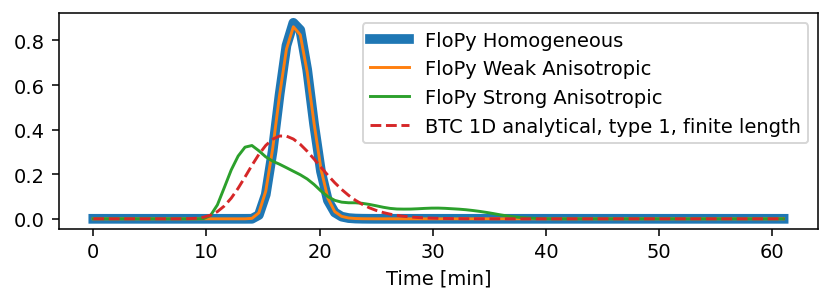

In [18]:
Conc_time_type1_t    = analytical_model_1D_finite_t1(xm[-1], times, v, al, xm[-1])        ; t_t0 = times - perlen_mt[0]
Conc_time_type1_t_t0 = analytical_model_1D_finite_t1(xm[-1], t_t0,  v, al, xm[-1])
Conc_pulse_solution  = Conc_time_type1_t - Conc_time_type1_t_t0
C_btc_h = np.mean([conc       [:, 0, :, -1]], axis=2)     ; C_btc_w = np.mean([conc_weak  [:, 0, :, -1]], axis=2)
C_btc_s = np.mean([conc_strong[:, 0, :, -1]], axis=2)     ; plt.figure(figsize=(7, 2), dpi=140)
plt.plot(times  /60, np.transpose(C_btc_h), linewidth = 5, label='FloPy Homogeneous')
plt.plot(times_w/60, np.transpose(C_btc_w),                label='FloPy Weak Anisotropic')
plt.plot(times_s/60, np.transpose(C_btc_s),                label='FloPy Strong Anisotropic')
plt.plot(times  /60, Conc_pulse_solution, '--',            label='BTC 1D analytical, type 1, finite length')
plt.xlabel('Time [min]')   ; plt.legend()    ; plt.show()

Model time: 5.48999989827474 min


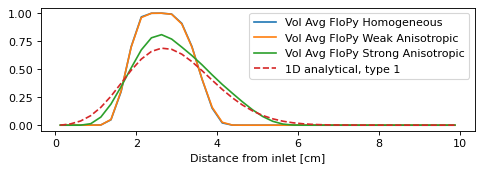

In [15]:
timestep = 10     ; print('Model time: ' + str(times[timestep]/60) + ' min') ; plt.figure(figsize=(7, 2), dpi=80)
C_profile_h = np.mean([conc[timestep,        0, :, :]], axis=1)
C_profile_w = np.mean([conc_weak[timestep,   0, :, :]], axis=1)
C_profile_s = np.mean([conc_strong[timestep, 0, :, :]], axis=1)
Conc_time_type1_x    = analytical_model_1D_finite_t1(xm-xm[0], times[timestep], v, al, xm[-1])     ; time_t0 = times[timestep] - perlen_mt[0]
Conc_time_type1_x_t0 = analytical_model_1D_finite_t1(xm-xm[0], time_t0,         v, al, xm[-1])
Conc_pulse_solution_in_space = Conc_time_type1_x - Conc_time_type1_x_t0
plt.plot(xm, np.transpose(C_profile_h), label='Vol Avg FloPy Homogeneous') ; plt.plot(xm, np.transpose(C_profile_w), label='Vol Avg FloPy Weak Anisotropic')
plt.plot(xm, np.transpose(C_profile_s), label='Vol Avg FloPy Strong Anisotropic') ; plt.plot(xm, Conc_pulse_solution_in_space, '--', label='1D analytical, type 1')
plt.xlabel('Distance from inlet [cm]') ; plt.legend() ; plt.show()